In [1]:
%matplotlib inline
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal, OneHotCategorical

/home/rasmus/.conda/envs/tflow15/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Parameters
K = 2 # 'K'lusters
sigma2 = np.array(0.5) # variance of noise
nData = 500 # samples
activation = tf.tanh
n_hidden = 4 # nHidden units
mu = np.array([-1.,1.])
# Numpy data - Gaussian mixture and corresponding OneHot vectors
def data(mu,K,nData):
    x_id = np.random.randint(0,K,(1,nData))    
    x_data = mu[x_id].T
    x_data = x_data + np.random.normal(0,sigma2,(nData,1))
    oneHot = np.squeeze(np.eye(K,K,dtype=np.int32)[x_id,:])
    return x_data,oneHot

x_data,oneHot=data(mu,K,nData)
print('x_data shape: ',x_data.shape)
print('oneHot shape: ',oneHot.shape)

x_data shape:  (500, 1)
oneHot shape:  (500, 2)


In [3]:
# Model
def neural_network(X):
    h = activation(tf.matmul(X, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return h
with tf.name_scope("model"):
    X = tf.placeholder(tf.float32, [nData,1], name="X")
    W_0 = Normal(loc=tf.zeros([1, n_hidden], dtype=tf.float32), scale=tf.ones([1, n_hidden], dtype=tf.float32), name="W_0")
    W_1 = Normal(loc=tf.zeros([n_hidden, K], dtype=tf.float32), scale=tf.ones([n_hidden, K], dtype=tf.float32), name="W_1")
    b_0 = Normal(loc=tf.zeros(n_hidden, dtype=tf.float32), scale=tf.ones(n_hidden, dtype=tf.float32), name="b_0")
    b_1 = Normal(loc=tf.zeros(K, dtype=tf.float32), scale=tf.ones(K, dtype=tf.float32), name="b_1")    
    Y = OneHotCategorical(logits=neural_network(X), name="out")

In [4]:
# Posterior
with tf.variable_scope("posterior"):
    with tf.variable_scope("qW_0"):
        loc = tf.get_variable("loc", [1, n_hidden])
        scale = tf.nn.softplus(tf.get_variable("scale", [1, n_hidden]))
        qW_0 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qW_1"):
        loc = tf.get_variable("loc", [n_hidden, K])
        scale = tf.nn.softplus(tf.get_variable("scale", [n_hidden, K]))
        qW_1 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qb_0"):
        loc = tf.get_variable("loc", [n_hidden])
        scale = tf.nn.softplus(tf.get_variable("scale", [n_hidden]))
        qb_0 = Normal(loc=loc, scale=scale)
    with tf.variable_scope("qb_1"):
        loc = tf.get_variable("loc", [K])
        scale = tf.nn.softplus(tf.get_variable("scale", [1]))
        qb_1 = Normal(loc=loc, scale=scale)

In [5]:
# Inference
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,}, data={X:x_data,Y:oneHot})
inference.initialize(n_iter=1000)

/home/rasmus/.conda/envs/tflow15/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/home/rasmus/.conda/envs/tflow15/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



{'t': 1, 'loss': 493.37875}
{'t': 101, 'loss': 47.00905}
{'t': 201, 'loss': 43.181732}
{'t': 301, 'loss': 52.77098}
{'t': 401, 'loss': 45.263283}
{'t': 501, 'loss': 58.483208}
{'t': 601, 'loss': 46.642334}
{'t': 701, 'loss': 46.931034}
{'t': 801, 'loss': 49.16552}
{'t': 901, 'loss': 48.551994}


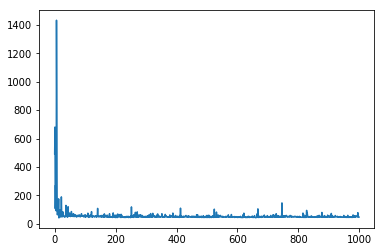

In [6]:
# Run
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%100 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
plt.plot(learning_curve)

In [7]:
# Evaluation
Y_post = ed.copy(Y, {W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,})

print('Train accuracy: ',ed.evaluate('categorical_accuracy', data={X:x_data,Y_post:oneHot}))
x_data_test,oneHot_test=data(mu,K,nData)
print('Test accuracy: ',ed.evaluate('categorical_accuracy', data={X:x_data_test,Y_post:oneHot_test}))

/home/rasmus/.conda/envs/tflow15/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/home/rasmus/.conda/envs/tflow15/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


Train accuracy:  0.984
Test accuracy:  0.974
